## Mini-Project 3:  Computer Vision using GPU and Transfer Learning


#### CSC 180 Intelligent Systems (Fall 2021)

#### Dr. Haiquan Chen, California State University, Sacramento

In [1]:
# Insert your name, your id, course title, assignment id, and due date here as comment 
#  Sharnpreet Singh - Id#: 219445227  
#  James Ochieng - Id#: 219285977
#  Palvinder Singh- Id#: 219445344
#  Due Date: Oct 28 2021


## Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [2]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Switch and Verify GPU

### To enable GPU backend for your notebook. Runtime->Change runtime type->Hardware Accelerator->GPU.

In [3]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

### If the above code output '/device:GPU:0',  you have switched to GPU successfully and you are ready to go. 



## Part I:   Image classification without transfer learning

https://www.cs.toronto.edu/~kriz/cifar.html

In [41]:
#  Load cifar-10 data and split it to training and test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

num_classes = 10

# The data split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [42]:
# print out data shape

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [43]:
# print out a random image in x_train as numpy array
x_train.shape[1:]

(32, 32, 3)

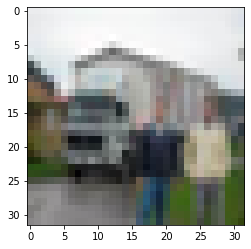

In [44]:
# print it out as image

import matplotlib.pyplot as plt


plt.imshow(x_train[16])

In [45]:
# Convert y_train from 2D to 1D 

y_train = y_train.reshape(50000)


In [46]:
y_train.shape

# expected output: (50000,)

(50000,)

In [47]:
# Convert y_test from 2D to 1D 

y_test = y_test.reshape(10000)


In [48]:
y_test.shape

# expected output: (10000,)

(10000,)

In [49]:
# Convert class vectors to one hot format

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((50000, 10), (10000, 10))

In [50]:
# Convert data from int to float and normalize it
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

###  Write your code in the cell below to create a CNN model which contains the following types of operations (layers):   

- Conv2D
- Activation
- MaxPooling2D
- Flatten
- Dropout
- Dense

### (optional) You are also encouraged to create multiple models with different activiation functions, different numbers of neurons and layers for performance comparison.

In [51]:

img_rows,img_cols=32,32
input_shape = (img_rows, img_cols, 3)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), padding='same',input_shape=input_shape))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dropout(0.25))
cnn.add(Dense(num_classes, activation='relu'))

cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(num_classes, activation="softmax"))

cnn.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
# Print model summary

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)         

### Write your code in the cell below for compile, earlystopping and fit. Notice that you should use earlystopping

In [53]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cnn.fit(x_train,y_train,batch_size=128,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
391/391 - 7s - loss: 1.7934 - accuracy: 0.3206 - val_loss: 1.4703 - val_accuracy: 0.4712
Epoch 2/1000
391/391 - 4s - loss: 1.4315 - accuracy: 0.4753 - val_loss: 1.2794 - val_accuracy: 0.5364
Epoch 3/1000
391/391 - 4s - loss: 1.3090 - accuracy: 0.5190 - val_loss: 1.1971 - val_accuracy: 0.5700
Epoch 4/1000
391/391 - 4s - loss: 1.2350 - accuracy: 0.5474 - val_loss: 1.1381 - val_accuracy: 0.5837
Epoch 5/1000
391/391 - 4s - loss: 1.1909 - accuracy: 0.5673 - val_loss: 1.1173 - val_accuracy: 0.5945
Epoch 6/1000
391/391 - 4s - loss: 1.1573 - accuracy: 0.5760 - val_loss: 1.0875 - val_accuracy: 0.6135
Epoch 7/1000
391/391 - 4s - loss: 1.1277 - accuracy: 0.5913 - val_loss: 1.0638 - val_accuracy: 0.6172
Epoch 8/1000
391/391 - 4s - loss: 1.1002 - accuracy: 0.6015 - val_loss: 1.0510 - val_accuracy: 0.6187
Epoch 9/1000
391/391 - 4s - loss: 1.0827 - accuracy: 0.6071 - val_loss: 1.0171 - val_accuracy: 0.6394
Epoch 10/1000
391/391 - 4s - loss: 1.0574 - accuracy: 0.6202 - val_loss: 1.0221 - 

### Write your code in the cell below to print out the Precision, Recall,  F1 score, and classification_*report*

### Include your findings in the project report. 

In [54]:

pred = cnn.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_true, pred)
print(cm)
print(classification_report(y_true, pred))


[[564  28  42  16  84   3   7  28 177  51]
 [ 13 795   0  10   7   4   7   5  42 117]
 [ 57   6 260 105 356  80  50  55  23   8]
 [  9   8  34 514 140 168  41  44  28  14]
 [  4   1  14  31 824  20  14  73  18   1]
 [  3   3  17 212 115 543   7  78  17   5]
 [  3   7  17  83 201  18 651   2  14   4]
 [  7   4   7  29 121  60   1 754   6  11]
 [ 15  20   4   8  19   6   4   7 891  26]
 [  4  51   2  13  17   2   7  28  43 833]]
              precision    recall  f1-score   support

           0       0.83      0.56      0.67      1000
           1       0.86      0.80      0.83      1000
           2       0.65      0.26      0.37      1000
           3       0.50      0.51      0.51      1000
           4       0.44      0.82      0.57      1000
           5       0.60      0.54      0.57      1000
           6       0.83      0.65      0.73      1000
           7       0.70      0.75      0.73      1000
           8       0.71      0.89      0.79      1000
           9       0.78     

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model.

### Include your findings in the project report.

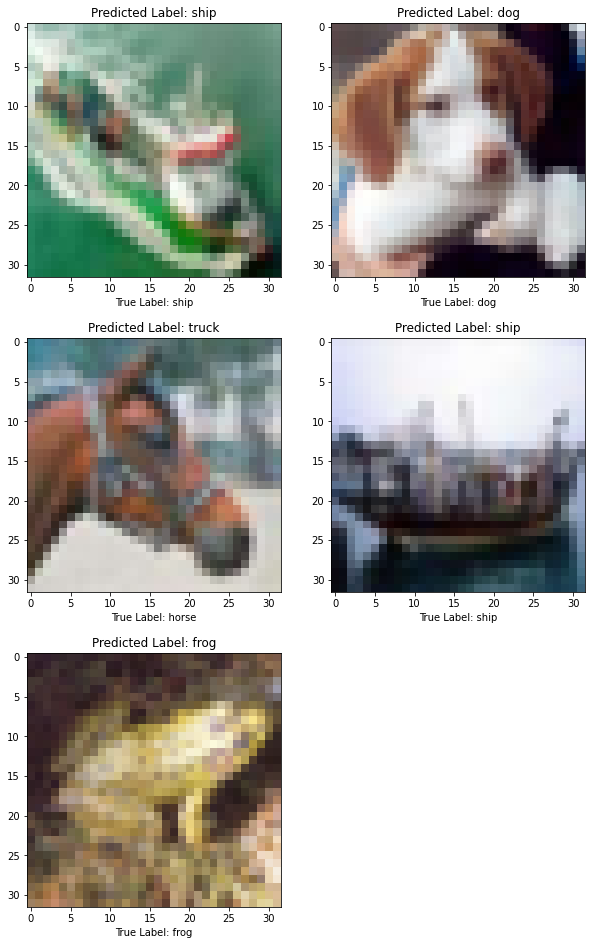

In [58]:
class_names=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]);
fig = plt.figure(figsize=(10, 16))
n=1;
for i in range(15,20):
  fig.add_subplot(3,2,n);
  plt.xlabel("True Label: " + class_names[y_true[i]]);
  plt.imshow(x_test[i]);
  plt.title("Predicted Label: " + class_names[pred[i]]);
  fig.subplots_adjust(top=0.9);
  n+=1;



## Part II:   CNN model with Transfer Learning

In [7]:
# We load data again.   The data split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()



print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


### Here we would like to use one pre-trained model called VGG16.   For more details on VGG16, please go to https://neurohive.io/en/popular-networks/vgg16/


### VGG16 supports down to 48x48 images as an input. However, the resolution of our images is too low, which is (32, 32) so we need to increase the resolution.   This is called upsampling. 



### Find a way to do upsampling for each image to increase its resolution from 32x32 to 64x64. One option is to use the function resize(), which is provided by scikit-image library (https://scikit-image.org/)


### Hints: 

#### (1) If you use resize() in scikit-image, that function also normalizes the input image so you may not want to normalize twice.

#### Learn from the examples here:  https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html

#### (2) Apply upsampling to x_train and x_test seperately. 

In [8]:
import skimage.transform
from skimage.transform import resize
from tensorflow.keras.applications import VGG16
#new_x_train = resize(x_train[0], (x_train[1].shape * 2,x_train[2].shape * 2))
new_x_train=np.zeros((50000,64,64,3));

#new_x_train.shape
for n,i in enumerate(x_train):
    new_x_train[n,:,:,:] = resize(x_train[n,:,:,:], (64,64), anti_aliasing=True)


#print(new_x_train[1:15])
# this process may take about a few minutes ....

In [9]:
del x_train;

In [10]:
new_x_test=np.zeros((10000,64,64,3));

#new_x_train.shape
for n,i in enumerate(x_test):
    new_x_test[n,:,:,:] = resize(x_test[n,:,:,:], (64,64), anti_aliasing=True)


# this process may take about a few minutes ....

In [11]:
del x_test;
del cnn;

In [12]:
print(new_x_test.shape);
print(new_x_train.shape);

(10000, 64, 64, 3)
(50000, 64, 64, 3)


### Write your code in the cell below to do the following:

- First convert y_train and y_test from 2D to 1D by using reshape() function 
- Next apply one-hot encoding to y_train and y_test by using tf.keras.utils.to_categorical() function

In [13]:
y_train = y_train.reshape(50000)
y_test = y_test.reshape(10000)

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [14]:
# double check shape

print(y_train.shape)
print(y_test.shape)


# expected output:  (50000, 10)
# expected output:  (10000, 10)

(50000, 10)
(10000, 10)


###  Load the pre-trained VGG16 model.  Write your code in the cell below to add each layer in VGG16 (excluding the top layers) to your new model.  

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer

model = Sequential()
for layer in vgg_model.layers:
    model.add(layer);

# print out the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

### Write your code in the cell below to freeze the weights in each layer in the new model

In [16]:
for layer in model.layers[:]:
    layer.trainable=False


###  Write your code in the cell below to add some "Dense" layers as top layers.

- Donot forget the output layer
- Choose the right activation fucntion for the output layer

In [17]:
model.add(Flatten())


# Add some "Dense" layers here, including output layer
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)      

###  Write your code below for compile and fit. 

### Train your new model. 

### Notice that you should use earlystopping.

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(new_x_train,y_train,batch_size=128,validation_data=(new_x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)


# since we use GPU, the training time for each epoch for the transferred model is about 60 seconds.  
# Let it run for a few epochs. 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
391/391 - 82s - loss: 1.2813 - accuracy: 0.5983 - val_loss: 1.0057 - val_accuracy: 0.6520
Epoch 2/1000
391/391 - 45s - loss: 0.8980 - accuracy: 0.6865 - val_loss: 0.9241 - val_accuracy: 0.6808
Epoch 3/1000
391/391 - 45s - loss: 0.8199 - accuracy: 0.7150 - val_loss: 0.9042 - val_accuracy: 0.6878
Epoch 4/1000
391/391 - 48s - loss: 0.7674 - accuracy: 0.7308 - val_loss: 0.9130 - val_accuracy: 0.6928
Epoch 5/1000
391/391 - 45s - loss: 0.7172 - accuracy: 0.7481 - val_loss: 0.9288 - val_accuracy: 0.6937
Epoch 6/1000
391/391 - 45s - loss: 0.6750 - accuracy: 0.7621 - val_loss: 0.9204 - val_accuracy: 0.6909
Epoch 7/1000
391/391 - 45s - loss: 0.6385 - accuracy: 0.7750 - val_loss: 0.9585 - val_accuracy: 0.6924
Epoch 8/1000
391/391 - 45s - loss: 0.6018 - accuracy: 0.7856 - val_loss: 0.9609 - val_accuracy: 0.6962
Epoch 00008: early stopping


In [39]:
del model;
del vgg_model;
del new_x_train;
del new_x_test;

### Write your code below to print out the Precision, Recall, F1 score, and classification_report

### Include your findings in the project report.

In [19]:
from sklearn import metrics

pred=model.predict(new_x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_true, pred)
print(cm)
print(classification_report(y_true, pred))

[[687  35 104  13  21   8  15  21  70  26]
 [ 13 864   8   8   2   8  22  10  21  44]
 [ 22  14 675  31  49  47 113  37   7   5]
 [ 19  38  70 422  39 195 123  53  21  20]
 [ 12  17  93  43 603  47  93  66  18   8]
 [  2  16  51 111  35 631  52  77   7  18]
 [  5  19  48  36  41  39 795   5   9   3]
 [  7  15  39  31  60  55  18 755   7  13]
 [ 37  56  26  11   5   4  13   6 816  26]
 [ 25 133   9  22   7  15  13  27  35 714]]
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1000
           1       0.72      0.86      0.78      1000
           2       0.60      0.68      0.64      1000
           3       0.58      0.42      0.49      1000
           4       0.70      0.60      0.65      1000
           5       0.60      0.63      0.62      1000
           6       0.63      0.80      0.70      1000
           7       0.71      0.76      0.73      1000
           8       0.81      0.82      0.81      1000
           9       0.81     

### Write your code in the cell below to show 3-5 images in the test set as well as their true labels and their labels predicted by your model with transfer learning. 

### Include your findings in the project report.

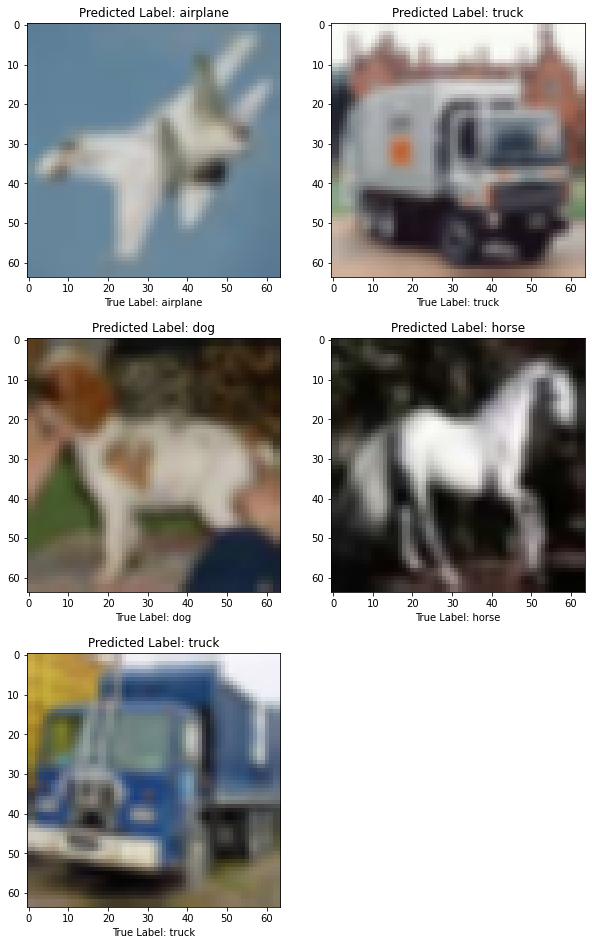

In [38]:

fig = plt.figure(figsize=(10, 16))
n=1;
for i in range(10,15):
  fig.add_subplot(3,2,n);
  plt.xlabel("True Label: " + class_names[y_true[i]]);
  plt.imshow(new_x_test[i]);
  plt.title("Predicted Label: " + class_names[pred[i]]);
  fig.subplots_adjust(top=0.9);
  n+=1;
